In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Program is Written for Demostration Purposes and Ultimately the PCA analysis does fail--- but just shows the data needs to be cleaned up/filtered better. 

# Load the Files of Interest

In [2]:
# Input File Names

# Files Downloaded from Broad on 4-25-2024
# DepMap Public 23Q4 Primary Files

# Meta Data File
cell_meta_data_file_name = "Model.csv"

# CRISPR File
crispr_file_name = "CRISPRGeneEffect.csv"


# Load the Meta Data

In [3]:
meta_dataframe = pd.read_csv(cell_meta_data_file_name)

# Get the shape of the dataframe
print ("Data Frame Shape")
print (meta_dataframe.shape)

meta_dataframe.head(5)

Data Frame Shape
(1921, 36)


,ModelID,PatientID,CellLineName,StrippedCellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,LegacyMolecularSubtype,...,TissueOrigin,CCLEName,CatalogNumber,PlateCoating,ModelDerivationMaterial,PublicComments,WTSIMasterCellID,SangerModelID,COSMICID,LegacySubSubtype
0,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,...,NaN,NIHOVCAR3_OVARY,HTB-71,None,NaN,NaN,2201.0,SIDM00105,905933.0,high_grade_serous
1,ACH-000002,PT-5qa3uk,HL-60,HL60,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,NaN,...,NaN,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,CCL-240,None,NaN,NaN,55.0,SIDM00829,905938.0,M3
2,ACH-000003,PT-puKIyc,CACO2,CACO2,COAD,Bowel,Colorectal Adenocarcinoma,Colon Adenocarcinoma,COAD,NaN,...,NaN,CACO2_LARGE_INTESTINE,HTB-37,None,NaN,NaN,NaN,SIDM00891,NaN,NaN
3,ACH-000004,PT-q4K2cp,HEL,HEL,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,NaN,...,NaN,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACC 11,None,NaN,NaN,783.0,SIDM00594,907053.0,M6
4,ACH-000005,PT-q4K2cp,HEL 92.1.7,HEL9217,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,NaN,...,NaN,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HEL9217,None,NaN,NaN,NaN,SIDM00593,NaN,M6


# Filter the Meta Data File Name
Remove "Organoid" Samples

In [4]:
meta_dataframe = meta_dataframe[meta_dataframe.GrowthPattern != "Organoid"]
print (meta_dataframe.shape)

(1897, 36)


Remove Normal Healthy Cell Lines

In [5]:
meta_dataframe = meta_dataframe[meta_dataframe.OncotreePrimaryDisease != "Non-Cancerous"]
print (meta_dataframe.shape)

(1766, 36)


# Extract Columns of Interest

In [6]:
filt_meta_df = meta_dataframe[["ModelID","StrippedCellLineName", 'OncotreeLineage']]
print (filt_meta_df.head(5))

      ModelID StrippedCellLineName       OncotreeLineage
0  ACH-000001            NIHOVCAR3  Ovary/Fallopian Tube
1  ACH-000002                 HL60               Myeloid
2  ACH-000003                CACO2                 Bowel
3  ACH-000004                  HEL               Myeloid
4  ACH-000005              HEL9217               Myeloid


# Count all the Unique Values in the OncotreeLineage Column

In [7]:
print(filt_meta_df['OncotreeLineage'].value_counts())

Lung                         243
Lymphoid                     211
Skin                         120
CNS/Brain                    117
Bowel                         88
Head and Neck                 84
Breast                        83
Esophagus/Stomach             82
Bone                          77
Myeloid                       74
Ovary/Fallopian Tube          74
Kidney                        69
Pancreas                      60
Peripheral Nervous System     56
Soft Tissue                   55
Biliary Tract                 43
Uterus                        41
Bladder/Urinary Tract         39
Pleura                        35
Liver                         28
Cervix                        25
Thyroid                       18
Eye                           14
Prostate                      12
Testis                         7
Vulva/Vagina                   5
Ampulla of Vater               4
Adrenal Gland                  1
Other                          1
Name: OncotreeLineage, dtype: int64


# Load the CRISPR Dataframe

In [8]:
crispr_dataframe = pd.read_csv(crispr_file_name)

# Get the shape of the dataframe
print ("Data Frame Shape")
print (crispr_dataframe.shape)

crispr_dataframe.head(5)

Data Frame Shape
(1100, 18444)


,Unnamed: 0,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000001,-0.122637,0.025881,0.034217,-0.128082,-0.031285,0.338046,-0.006439,-0.093642,0.189186,...,-0.131727,-0.039829,0.179405,0.283552,0.204513,-0.289724,-0.062972,0.074180,0.111244,-0.467908
1,ACH-000004,0.019756,-0.083640,-0.060118,-0.027417,-0.036116,-0.001056,0.312876,-0.086897,0.204434,...,-0.170329,-0.454263,0.194583,0.098989,0.126948,0.032983,-0.410392,0.113156,0.234388,-0.088306
2,ACH-000005,-0.107208,-0.023211,0.200204,0.116039,-0.172227,-0.071294,0.203270,-0.127806,-0.090981,...,-0.301695,-0.454969,-0.061959,-0.036427,0.016602,-0.201273,-0.178877,-0.055349,-0.002161,-0.186842
3,ACH-000007,-0.031027,-0.137850,0.067704,0.107988,0.007992,0.124945,0.049548,-0.220824,-0.165669,...,-0.303390,-0.507272,-0.025400,0.236659,0.072010,-0.100344,-0.462160,-0.001555,-0.325964,-0.486660
4,ACH-000009,0.008888,-0.146566,0.084471,0.089419,0.065109,0.027841,0.087943,-0.161369,0.041121,...,-0.255466,-0.288739,-0.037132,0.261444,-0.062391,-0.112703,-0.598698,0.095877,-0.026742,-0.320759


# Merge the Meta Dataframe and CRISPR Dataframe

In [9]:
merged_dataframe = pd.merge(filt_meta_df, crispr_dataframe, left_on='ModelID', right_on='Unnamed: 0', how="inner")
merged_dataframe.head(5)

,ModelID,StrippedCellLineName,OncotreeLineage,Unnamed: 0,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000001,NIHOVCAR3,Ovary/Fallopian Tube,ACH-000001,-0.122637,0.025881,0.034217,-0.128082,-0.031285,0.338046,...,-0.131727,-0.039829,0.179405,0.283552,0.204513,-0.289724,-0.062972,0.074180,0.111244,-0.467908
1,ACH-000004,HEL,Myeloid,ACH-000004,0.019756,-0.083640,-0.060118,-0.027417,-0.036116,-0.001056,...,-0.170329,-0.454263,0.194583,0.098989,0.126948,0.032983,-0.410392,0.113156,0.234388,-0.088306
2,ACH-000005,HEL9217,Myeloid,ACH-000005,-0.107208,-0.023211,0.200204,0.116039,-0.172227,-0.071294,...,-0.301695,-0.454969,-0.061959,-0.036427,0.016602,-0.201273,-0.178877,-0.055349,-0.002161,-0.186842
3,ACH-000007,LS513,Bowel,ACH-000007,-0.031027,-0.137850,0.067704,0.107988,0.007992,0.124945,...,-0.303390,-0.507272,-0.025400,0.236659,0.072010,-0.100344,-0.462160,-0.001555,-0.325964,-0.486660
4,ACH-000009,C2BBE1,Bowel,ACH-000009,0.008888,-0.146566,0.084471,0.089419,0.065109,0.027841,...,-0.255466,-0.288739,-0.037132,0.261444,-0.062391,-0.112703,-0.598698,0.095877,-0.026742,-0.320759


# Drop the Duplicate ACH Column

In [10]:
# Drop column 'B'
merged_dataframe.drop('Unnamed: 0', axis=1, inplace=True) 

merged_dataframe.head(5)

,ModelID,StrippedCellLineName,OncotreeLineage,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000001,NIHOVCAR3,Ovary/Fallopian Tube,-0.122637,0.025881,0.034217,-0.128082,-0.031285,0.338046,-0.006439,...,-0.131727,-0.039829,0.179405,0.283552,0.204513,-0.289724,-0.062972,0.074180,0.111244,-0.467908
1,ACH-000004,HEL,Myeloid,0.019756,-0.083640,-0.060118,-0.027417,-0.036116,-0.001056,0.312876,...,-0.170329,-0.454263,0.194583,0.098989,0.126948,0.032983,-0.410392,0.113156,0.234388,-0.088306
2,ACH-000005,HEL9217,Myeloid,-0.107208,-0.023211,0.200204,0.116039,-0.172227,-0.071294,0.203270,...,-0.301695,-0.454969,-0.061959,-0.036427,0.016602,-0.201273,-0.178877,-0.055349,-0.002161,-0.186842
3,ACH-000007,LS513,Bowel,-0.031027,-0.137850,0.067704,0.107988,0.007992,0.124945,0.049548,...,-0.303390,-0.507272,-0.025400,0.236659,0.072010,-0.100344,-0.462160,-0.001555,-0.325964,-0.486660
4,ACH-000009,C2BBE1,Bowel,0.008888,-0.146566,0.084471,0.089419,0.065109,0.027841,0.087943,...,-0.255466,-0.288739,-0.037132,0.261444,-0.062391,-0.112703,-0.598698,0.095877,-0.026742,-0.320759


In [11]:
# Cancer of Interest
list_of_cancers = ['Lung', 'Lymphoid', 'Skin', 'CNS/Brain', 'Bowel']
print (list_of_cancers)

['Lung', 'Lymphoid', 'Skin', 'CNS/Brain', 'Bowel']


# Filter For Columns With Specific Cancer Types

In [12]:
filt_merg_dataframe = merged_dataframe.loc[merged_dataframe['OncotreeLineage'].isin(list_of_cancers)]
filt_merg_dataframe.head(5)

,ModelID,StrippedCellLineName,OncotreeLineage,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
3,ACH-000007,LS513,Bowel,-0.031027,-0.137850,0.067704,0.107988,0.007992,0.124945,0.049548,...,-0.303390,-0.507272,-0.025400,0.236659,0.072010,-0.100344,-0.462160,-0.001555,-0.325964,-0.486660
4,ACH-000009,C2BBE1,Bowel,0.008888,-0.146566,0.084471,0.089419,0.065109,0.027841,0.087943,...,-0.255466,-0.288739,-0.037132,0.261444,-0.062391,-0.112703,-0.598698,0.095877,-0.026742,-0.320759
6,ACH-000012,HCC827,Lung,-0.096631,-0.024440,0.041922,0.039121,0.028947,-0.046776,0.205319,...,-0.489292,-0.770445,0.079890,0.024572,-0.073663,0.005124,-0.131949,-0.109147,-0.164482,-0.277397
8,ACH-000015,NCIH1581,Lung,-0.099040,-0.070409,-0.029389,0.084594,-0.052288,0.133941,0.156356,...,-0.340179,-0.344215,-0.016988,0.078385,0.064771,-0.005409,-0.216393,-0.137350,-0.168087,-0.282338
12,ACH-000021,NCIH1693,Lung,-0.115407,-0.181106,-0.020465,-0.025030,-0.109040,-0.046873,0.067041,...,-0.206325,-0.483075,0.067936,0.066914,0.037309,-0.066436,-0.368909,-0.127135,-0.249770,-0.357243


# Get the Gene Columns (aka "features")

In [13]:
# Get List of the Headers
column_headers = filt_merg_dataframe.columns.tolist()
#print (column_headers)

# Get the Gene Columns ONLY
feature_columns = column_headers[3:]
#print (feature_columns)


x = filt_merg_dataframe.loc[:, feature_columns].values
#print (x)

# See Histogram Spread of Data (see noise driving things)

(array([6.300000e+01, 4.670000e+02, 3.754000e+03, 3.385300e+04,
        1.359840e+05, 3.743340e+05, 5.272412e+06, 1.574893e+06,
        5.420000e+02, 2.300000e+01]),
 array([-5.47070503, -4.67764326, -3.88458148, -3.0915197 , -2.29845792,
        -1.50539615, -0.71233437,  0.08072741,  0.87378919,  1.66685096,
         2.45991274]),
 <BarContainer object of 10 artists>)

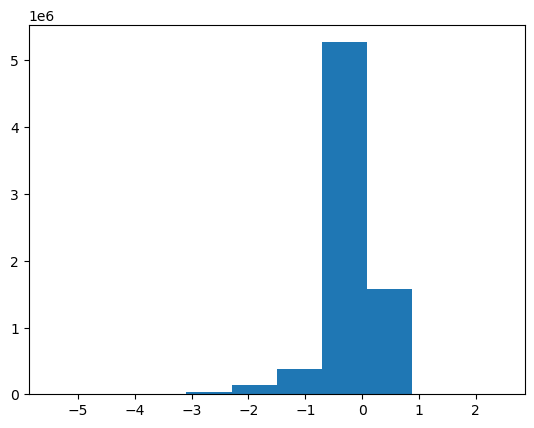

In [28]:
feature_dataframe_subset= filt_merg_dataframe[feature_columns]

# See Distribution of dataframe
plt.hist(feature_dataframe_subset.to_numpy().flatten())

In [14]:
# Load Packages
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the Dataframe

In [19]:
# Standardize the Dataframe
x = StandardScaler().fit_transform(x)
print (x)

[[ 0.08297133 -0.46159483  0.25566852 ...  0.11751692 -1.31607166
  -1.03117856]
 [ 0.48882642 -0.54311153  0.42582658 ...  0.90190477  1.19659467
  -0.02862223]
 [-0.58407519  0.59916918 -0.00598374 ... -0.74865968  0.03994631
   0.23342054]
 ...
 [ 0.35137906 -0.19492868 -0.29349494 ... -0.06525332 -0.77660527
   0.44559614]
 [ 0.3430952  -0.00919242  0.70194854 ... -0.68673064  0.74473602
  -0.33845886]
 [ 0.29704987 -0.29288638  0.01609186 ... -1.44060671 -0.31205572
  -1.03036398]]


# Missing Data in the Dataframe (PCA Program Yells at you!!!)

In [18]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Create an imputer object with mean strategy
imputer = SimpleImputer(strategy="mean")

# Impute missing values
imputed_data = imputer.fit_transform(x)


[[ 0.08297133 -0.46159483  0.25566852 ...  0.11751692 -1.31607166
  -1.03117856]
 [ 0.48882642 -0.54311153  0.42582658 ...  0.90190477  1.19659467
  -0.02862223]
 [-0.58407519  0.59916918 -0.00598374 ... -0.74865968  0.03994631
   0.23342054]
 ...
 [ 0.35137906 -0.19492868 -0.29349494 ... -0.06525332 -0.77660527
   0.44559614]
 [ 0.3430952  -0.00919242  0.70194854 ... -0.68673064  0.74473602
  -0.33845886]
 [ 0.29704987 -0.29288638  0.01609186 ... -1.44060671 -0.31205572
  -1.03036398]]


# Convert Dataframe to Principal Components

In [20]:
# Convert Dataframe to two Principal Components
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(imputed_data)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# Add Labels Back Into the Data for the Groups

In [22]:
# Merge Label Back Into Data
finalDf = pd.concat([principalDf, filt_merg_dataframe[['OncotreeLineage']]], axis = 1)

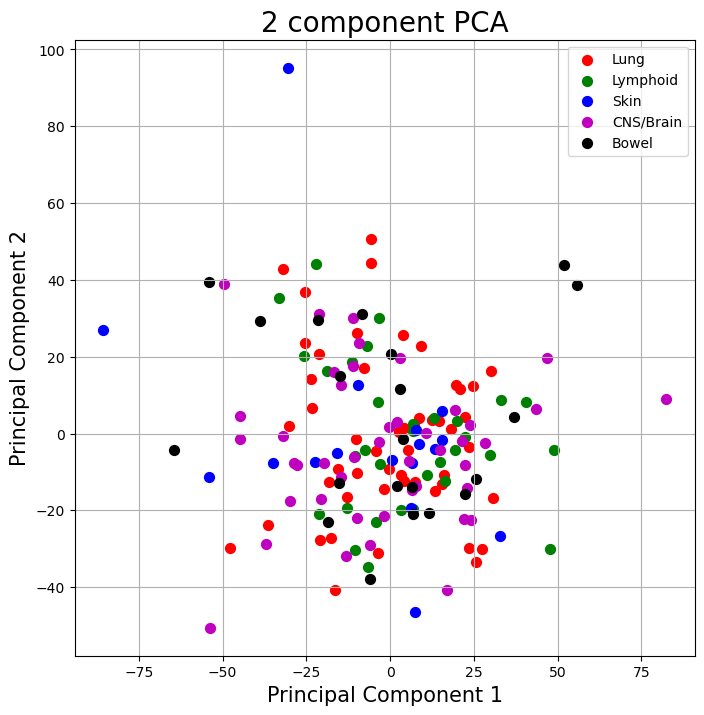

In [24]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['Lung', 'Lymphoid', 'Skin', 'CNS/Brain', 'Bowel']
colors = ['r', 'g', 'b', 'm', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['OncotreeLineage'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Clearly the Gene Effect Scores Need to Be Filtered Better.... Overall PCA Analysis Slightly Failed and Most Likely Driven By Outliers